# Activation Statistics

> Exploring what we can learn by closely inspecting the model internal distributions

Adapted from:
- https://youtu.be/9YZaYjRKuEc?si=x6C8pPH2--BYKZ2T&t=3308

We need to have a way of looking inside models and diagnosing issues. 

In [1]:
#| default_exp activations

In [2]:
# |export
import random
from contextlib import contextmanager
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import Tensor, nn
from torchmetrics.classification import MulticlassAccuracy

from slowai.datasets import get_grid, show_image
from slowai.learner import (
    Callback,
    DeviceCB,
    MetricsCB,
    ProgressCB,
    TrainLearner,
    fashion_mnist,
    to_cpu,
)

In [3]:
# |export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
set_seed(42)
plt.style.use("ggplot")

## Baseline

Let's look at a fashion MNIST classification problem. 

In [5]:
# |export
class Conv2dWithReLU(nn.Module):
    @fc.delegates(nn.Conv2d)
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(*args, **kwargs)

    def forward(self, x):
        return F.relu(self.conv(x))


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Conv2dWithReLU(1, 8, kernel_size=5, stride=2, padding=2),  # 14x14
            Conv2dWithReLU(8, 16, kernel_size=3, stride=2, padding=1),  # 7x7
            Conv2dWithReLU(16, 32, kernel_size=3, stride=2, padding=1),  # 4x4
            Conv2dWithReLU(32, 64, kernel_size=3, stride=2, padding=1),  # 2x2
            nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),  # 1x1
        )

    def forward(self, x):
        return rearrange(self.layers(x), "bs c w h -> bs (c w h)")

Generally, we want a high learning rate to come up with generalizable algorithms. Let's start with the relatively high 0.6.

MulticlassAccuracy,loss,epoch,train
0.160,2.911,0,train
0.100,2.305,0,eval


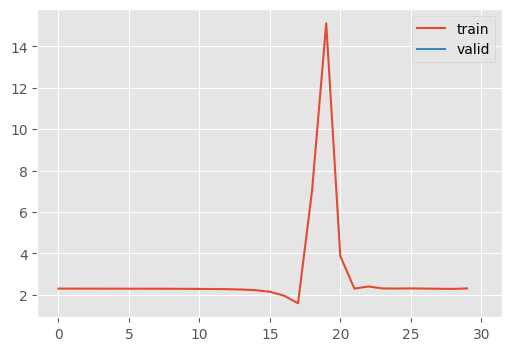

In [6]:
def train(model, extra_cbs=None):
    cbs = [
        MetricsCB(MulticlassAccuracy(num_classes=10)),
        DeviceCB(),
        ProgressCB(plot=True),
    ]
    if extra_cbs:
        cbs.extend(extra_cbs)
    learn = TrainLearner(
        model,
        fashion_mnist(),
        F.cross_entropy,
        lr=0.6,
        cbs=cbs,
    ).fit()
    return learn


train(model=CNN())

Let's look at the underlying activations

## Hooks

Jeremy's implementation is kind of a mess so I did a bit of refactoring. Hooks are just another kind of callback, so we can adopt our `Callback` conventions.

In [7]:
#| export
class Hook:
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))

    def remove(self):
        self.hook.remove()

    def __del__(self):
        self.remove()

In [8]:
#| export
class HooksCallback(Callback):
    def __init__(
        self,
        hook_cls,
        mods=None,
        mod_filter=fc.noop,
        on_train=True,
        on_valid=False,
    ):
        fc.store_attr()

    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = [self.hook_cls(m) for m in mods]

    def cleanup_fit(self, learn):
        for h in self.hooks:
            h.remove()

    def __iter__(self):
        return iter(self.hooks)

    def __len__(self):
        return len(self.hooks)

That being implemented, we can subclass these for adding hook behaviors.

In [9]:
#| export
class StoreModuleStats(Hook):
    def __init__(self, m, on_train=True, on_valid=False):
        self.moments = []
        self.hists = []
        self.on_train = on_train
        self.on_valid = on_valid

        def append_moments(module, _, activations):
            trn = self.on_train and module.training
            vld = self.on_valid and not module.training
            if trn or vld:
                a = to_cpu(activations)
                self.moments.append((a.mean(), a.std()))
                self.hists.append(a.abs().histc(40, 0, 10))

        self.hook = m.register_forward_hook(append_moments)

    def plot(self, ax0, ax1, label):
        means, stds = zip(*self.moments)
        ax0.plot(means, label=label)
        ax1.plot(stds)

In [10]:
#| export
class StoreModuleStatsCB(HooksCallback):
    def __init__(
        self,
        mods=None,
        mod_filter=fc.noop,
        on_train=True,
        on_valid=False,
    ):
        fc.store_attr()
        self.hook_cls = StoreModuleStats

    def after_fit(self, learn):
        fig, axes = get_grid(len(self.hooks))
        for ax, h in zip(axes.flatten(), self.hooks):
            hist = torch.stack(h.hists).T.float().log1p()
            show_image(hist, ax, origin="lower")
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        fig.tight_layout()
        for i, h in enumerate(self.hooks):
            layer = model.layers[i]
            h.plot(*axes, label=f"layer {i}: {type(layer)}")
        fig.legend()
        fig.tight_layout()

Now, we can rerun while keeping track of the activation stats

MulticlassAccuracy,loss,epoch,train
0.166,2.275,0,train
0.250,1.999,0,eval


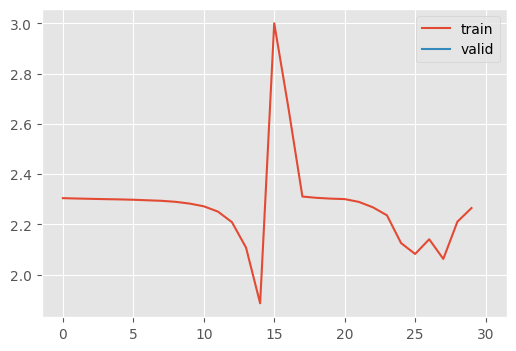

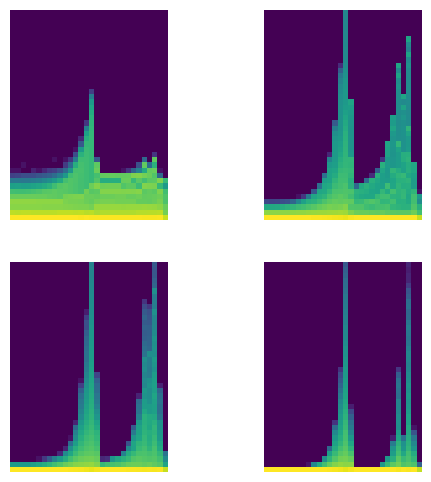

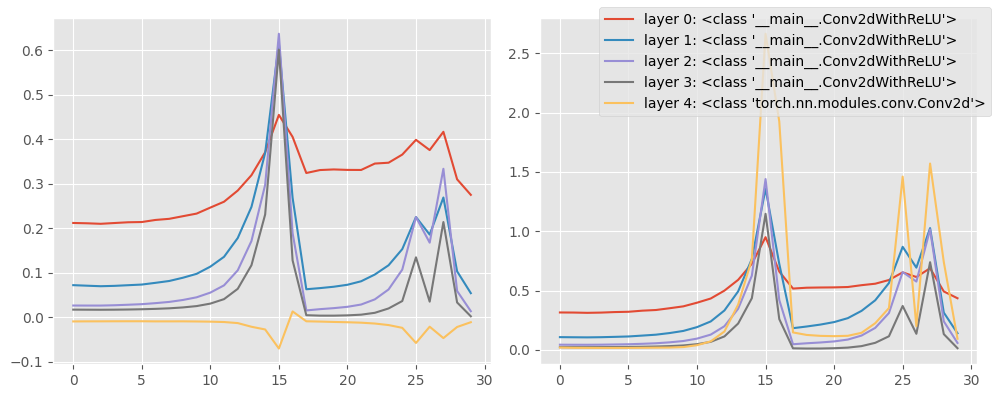

In [11]:
model = CNN()
train(
    model=model,
    extra_cbs=[StoreModuleStatsCB(mods=model.layers)],
)

Jeremy makes the point that his network isn't training because the weights are close to 0, which makes them "dead units."

Generally, the mean should be 0 and the standard deviation should be close to 1.

Ultimately, Jeremy recommends simply abandoning any training run where the activation variance increases and crashes.

In [12]:
#| hide
import nbdev

nbdev.nbdev_export()